<a href="https://colab.research.google.com/github/tsainez/examples/blob/master/LC_algorithm_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/UCMerced-ML/LC-model-compression

Cloning into 'LC-model-compression'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 166 (delta 63), reused 142 (delta 42), pack-reused 0
Receiving objects: 100% (166/166), 3.19 MiB | 5.32 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [ ]:
! pip3 install -e ./LC-model-compression

Obtaining file:///content/LC-model-compression
  Running setup.py develop for lc


## IMPORTANT!
At this point you need to restart the runtime by doing "Runtime => Restart Runtime"

In [ ]:
import lc
from lc.torch import ParameterTorch as Param, AsVector, AsIs
from lc.compression_types import ConstraintL0Pruning, LowRank, RankSelection, AdaptiveQuantization
from lc.models.torch import lenet300_classic, lenet300_modern_drop, lenet300_modern

import numpy as np

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import datasets
torch.set_num_threads(4)

## Data
We use a subset of the MNIST dataset. The dataset contains subtracted 28x28 grayscale images with digits 0, 2, 5, 6, and 7. The images are normalized to have grayscale value 0 to 1 and then mean is subtracted.

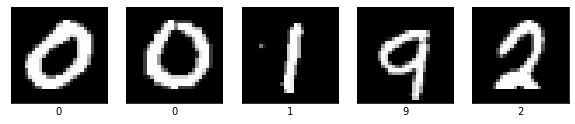

In [ ]:
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [10, 5]
def show_MNIST_images():
    train_data_th = datasets.MNIST(root='./datasets', download=True, train=True)
    data_train = np.array(train_data_th.data[:])
    targets = np.array(train_data_th.targets)
    images_to_show = 5
    random_indexes = np.random.randint(data_train.shape[0], size=images_to_show)
    for i,ind in enumerate(random_indexes):
        plt.subplot(1,images_to_show,i+1)
        plt.imshow(data_train[ind], cmap='gray')
        plt.xlabel(targets[ind])
        plt.xticks([])
        plt.yticks([])
show_MNIST_images()

In [ ]:
def data_loader(batch_size=2048, n_workers=4):
    train_data_th = datasets.MNIST(root='./datasets', download=True, train=True)
    test_data_th = datasets.MNIST(root='./datasets', download=True, train=False)

    # Get subset of digits that we will be using
    indices = (train_data_th.targets == 0) | (train_data_th.targets == 2) | (train_data_th.targets == 5) | (train_data_th.targets == 6) | (train_data_th.targets == 7)
    train_data, train_targets = train_data_th.data[indices], train_data_th.targets[indices]

    indices = (test_data_th.targets == 0) | (test_data_th.targets == 2) | (test_data_th.targets == 5) | (test_data_th.targets == 6) | (test_data_th.targets == 7)
    test_data, test_targets = test_data_th.data[indices], test_data_th.targets[indices]

    # Change labels to be in range 0 - C-1 so cross entropy function works
    for i, digit in enumerate([0,2,5,6,7]):
        train_targets = torch.where(train_targets == digit, i, train_targets)
        test_targets = torch.where(test_targets == digit, i, test_targets)

    data_train = np.array(train_data[:]).reshape([-1, 28 * 28]).astype(np.float32)
    data_test = np.array(test_data[:]).reshape([-1, 28 * 28]).astype(np.float32)

    data_train = (data_train / 255)
    dtrain_mean = data_train.mean(axis=0)
    data_train -= dtrain_mean
    data_test = (data_test / 255).astype(np.float32)
    data_test -= dtrain_mean

    train_data = TensorDataset(torch.from_numpy(data_train), train_targets)

    # Create validation set
    val_split = int(0.3 * len(train_data))
    train_data, val_data = random_split(train_data, [len(train_data) - val_split, val_split], generator=torch.Generator().manual_seed(1778))

    test_data = TensorDataset(torch.from_numpy(data_test), test_targets)

    train_loader = DataLoader(train_data, num_workers=n_workers, batch_size=batch_size, shuffle=True,)
    val_loader = DataLoader(val_data, num_workers=n_workers, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, num_workers=n_workers, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## Our Subset of MNIST

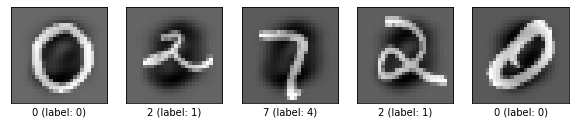

In [ ]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [10, 5]
label_map = {0: 0, 1: 2, 2: 5, 3: 6, 4: 7}
def show_subset_MNIST_images(images_to_show):
    first_batch, labels = next(iter(data_loader(images_to_show)[0]))
    data_train = np.array(first_batch[:]).reshape(-1, 28, 28)
    targets = np.array(labels)
    for i in range(images_to_show):
        plt.subplot(1,images_to_show,i+1)
        plt.imshow(data_train[i], cmap='gray')
        plt.xlabel(str(label_map[targets[i]]) + " (label: " + str(targets[i]) + ")")
        plt.xticks([])
        plt.yticks([])
show_subset_MNIST_images(5)

## Helper Functions

In [ ]:
def compute_acc_loss(forward_func, data_loader):
    correct_cnt, ave_loss = 0, 0
    for batch_idx, (x, target) in enumerate(data_loader):
        with torch.no_grad():
            target = target.cuda()
            score, loss = forward_func(x.cuda(), target)
            _, pred_label = torch.max(score.data, 1)
            correct_cnt += (pred_label == target.data).sum().item()
            ave_loss += loss.data.item() * len(x)
    accuracy = correct_cnt * 1.0 / len(data_loader.dataset)
    ave_loss /= len(data_loader.dataset)
    return accuracy, ave_loss

def train_test_acc_eval_f(net):
    train_loader, _, test_loader = data_loader()
    def forward_func(x, target):
        y = net(x)
        return y, net.loss(y, target)
    with torch.no_grad():
        acc_train, loss_train = compute_acc_loss(forward_func, train_loader)
        acc_test, loss_test = compute_acc_loss(forward_func, test_loader)

    print(f"Train err: {100-acc_train*100:.2f}%, train loss: {loss_train}")
    print(f"TEST ERR: {100-acc_test*100:.2f}%, test loss: {loss_test}")
  
def train_val_acc_eval_f(net):
    train_loader, val_loader, _ = data_loader()
    def forward_func(x, target):
        y = net(x)
        return y, net.loss(y, target)
    with torch.no_grad():
        acc_train, loss_train = compute_acc_loss(forward_func, train_loader)
        acc_val, loss_val = compute_acc_loss(forward_func, val_loader)

    return acc_train, loss_train, acc_val, loss_val

def visualize_errs(errs, subset, parameters):
    epochs = np.arange(len(errs))
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(epochs, errs)
    ax.set_xlabel('Epoch')                                                # When plotting error per epoch
    ax.set_title(subset + ' Error per Epoch with ' + str(parameters))     # When plotting error per epoch
    #ax.set_xlabel('SGD Step')                                            # When plotting error per SGD step
    #ax.set_title(subset + ' Error per SGD step with ' + str(parameters)) # When plotting error per SGD step
    ax.set_ylabel(subset + ' Error')
    ax.set_xscale('linear')
    ax.set_yscale('log')

##Reference Network
We use cuda capable GPU for our experiments. The network has 3 fully-connected layers with dimensions 784x300, 300x100, and 100x5, and the total of 266105 parameters (which includes biases).


In [ ]:
device = torch.device('cuda') 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.loss = torch.nn.CrossEntropyLoss()
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 5)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_net(net, parameters):
    train_errs = []
    val_errs = []

    max_val_acc = 0
    #min_val_loss = np.inf
    epochs_per_early_stop_check = parameters["epochs_per_early_stop_check"]
    early_stop_thresh = 1e-5
    intitial_early_stop_patience = 3
    early_stop_patience = intitial_early_stop_patience

    train_loader, _, _ = data_loader(parameters["batch_size"])
    params = list(filter(lambda p: p.requires_grad, net.parameters()))
    optimizer = optim.SGD(params, 
                          lr=parameters["lr"], 
                          momentum=parameters["momentum"], 
                          weight_decay=parameters["weight_decay"],
                          nesterov = parameters["nesterov"])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=parameters["step_size"], gamma=parameters["gamma"])
    max_epochs=100
    for epoch in range(max_epochs):
        avg_loss = []
        for x, target in train_loader:
            optimizer.zero_grad()
            x = x.cuda()
            target = target.cuda().to(dtype=torch.long)
            out = net(x)
            loss = net.loss(out, target)
            avg_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            # -------------------------------------------------------------------------------

            # ------------------------------------------------------------------------------- 
        scheduler.step()

        print(f"\tepoch #{epoch} is finished.")
        print(f"\t  avg. train loss: {np.mean(avg_loss):.6f}")
        ## Note: when preparing final report, this chunk should be put in the inner loop
        ## to record errors for each SGD step, rather than just for each epoch (visualize
        ## errs function should also be modified accordingly)
        ## During hyperparameter tuning, it will be sufficient to find error rates only
        ## on each epoch
        # ------------------------------------------------------------------------------- 
        acc_train, loss_train, acc_val, loss_val = train_val_acc_eval_f(net.eval())
        print(f"\tTrain err: {100-acc_train*100:.2f}%, train loss: {loss_train}")
        print(f"\tValidation err: {100-acc_val*100:.5f}%, validation loss: {loss_val}\n")
        train_errs.append(1 - acc_train)
        val_errs.append(1 - acc_val)
        # ------------------------------------------------------------------------------- 
        #if (min_val_loss - early_stop_thresh > loss_val):
        if (epoch % epochs_per_early_stop_check == epochs_per_early_stop_check - 1):
            if (max_val_acc + early_stop_thresh < acc_val):
                #min_val_loss = loss_val
                max_val_acc = acc_val
                early_stop_patience = intitial_early_stop_patience
            else:
                early_stop_patience -= 1
            if (early_stop_patience == 0):
                break;
    
    visualize_errs(train_errs, "Train", parameters)
    visualize_errs(val_errs, "Validation", parameters)

##Parameter Selection
We use Stochastic Gradient Descent and try to find the optimal combination of momentum, batch size, learning rate, and l2 regularization.

In [ ]:
# Batch size: powers of 2 (2^0 (batch-size 1) to 2^16 (gradient descent)) # very small batch sizes take a long time for each epoch, very large batch sizes take longer to converge
# likewise, patience too high for very small batch size
# lr: small positive number to value at which train loss oscillates up and down from very start of training (perhaps try 1e-5 - 1e4)
# gamma (factor by which learning rate decreases): small positive number to 1
# step size (how many epochs pass between each lr scheduler step): integers from 1 up
# momentum (addition of previous SGD step vector to current SGD step vector): 0 - 1 
# weight decay (penalty to loss for magnitude of weights): 0 to very large number (train error doesn't decrease because CELoss term dwarfed by weight magnitude loss term)
# nesterov (something to do with SGD, similar to momentum but looking at next update instead of previous): True or False

# Notes: 
# Wanted to find a way so that we didn't have to train every model for a long time regardless of how fast it converged, but still be able to show that validation error either increases
# or flattens out before giving up on a particular selection of hyperparameters
#   Decided to set a maximum number of epochs and use early stopping with a threshold of 1e-5 on validation accuracy to determine when to stop
#   Result is that (as long as the model didn't take longer than 100 epochs to converge) the validation accuracy curve will at least be flat for some time before stopping training
#   introduced a new hyperparameter, epochs_per_early_stop_check, since some selections of hyperparameters will naturally take longer to converge than others
#     Training loop will only check to see if validation accuracy hasn't improved every <epochs_per_early_stop_check> epochs, allowing us to give more time to models
#     that naturally take longer to improve significantly
#     If validation accuracy hasn't improved by at least 1e-5 (.001%) since its last check, a counter is decremented. If this occurs three times, the training loop breaks
#
# Started by seeing if I could find a smaller, reasonable range of batch sizes
# for batch sizes 2^0, 2^1, 2^2 epochs each took a while and train error barely decreased, sometimes going up (lr may need to be lower in these cases)
# for batch size 2^16 (gradient descent), early stopping settings were too stringent and the model wasn't given time to converge - patience should be higher for higher batch size
# Changing learning rate to 0.01 on very small batch sizes worked very well, going to check progressively larger batch sizes to see if the learning rate is better in general
#   Lower batch sizes make epochs take longer, but the model converges to a good accuracy in fewer epochs - initial run kept going for too long after min validation error reached
#     so I reduced epochs per early stop check and trained again: validation error to beat 1.05144% (batch_size 8, lr: .01, epochs_per_early_stop_check: 3)
#   batch size 16 not doing better on val set than batch size 8 with same lr - validation accuracy flattens
#   batch sizes up to 256 weren't doing better than bs 8 with lr 0.01, so I tried increasing lr for larger batch sizes up to 0.05 and allowed model to train longer
#     models trained in this way consistently reached a minimal train and validation error and almost completely stopped moving from that point on
#     played around a bit with gamma and step size, but model error would consistently bottom and not oscillate, so I assumed the values were good as they were
# Found that learning rates around 1 either don't work at all for smaller batch sizes, or oscillate a bit at the start then start behaving as lr_scheduler decreases it over time for larger 
#     batch sizes
# For gradient descent (batch_size 2**16), learning rate starting at about 1 works well, but a learning rate as high as 2 doesn't even work well on a very large batch size
#   Decreasing gamma helped with this, but it still underperforms compared to starting at a lower lr
# Decided to set learning rate range to be small positive number to 2. 
# 
# Best results so far have been found by setting lr relatively low and having batch size very low. In effect we are taking a very large amount of small steps towards
#   the minimizer, but I wonder if increasing the number of training epochs with a lower gamma and higher batch size may have the same effect but faster. Note: by the end of the first
#   epoch with very small batch size, the training error is typically already around 1% and validation error less than 2%
#   I have also noticed that training error will very quickly go down to 0%, and once there, the validation accuracy barely changes. 
#   I also wonder if decreasing the gamma a bit with small batch size and lr may allow us to reach a lower minimum, since I've seen the validation error reach a lower value but then
#   increase and settle at a slightly higher value later in training
# Tried decreasing gamma on lower batch size, best model is bs 4, lr .005, gamma .9, epochs per early stop check 2, with val accuracy of 0.94969%
# Trying to get results comparable to low batch size with a batch size of 256, by varying lr, gamma, and step size
#   While trying to do the above, we were kicked out of google colab and unable to get access to a GPU the same day
#   When we went back the next day, we were unable to get the above results with as low of valudation error as we initially could, but we were able to get a model with a more
#   reasonable batch size of 128 that had validation accuracy almost as low as the other one. Since we knew that we could get kicked out of google colab again with little time
#   left to finish the project, we decided to stick with this as our final model
# Models with larger batch sizes tended to end the first training epoch with higher validation error, likely since they have fewer SGD updates before we check the error,
#   but always converged to a point of near-zero training error where the validation error was completely flat for many epochs. Models with smaller batch sizes took fewer
#   epochs to train, and started out at lower error rates, but would generally not improve past the point that training error began to read 0% (which happened very quickly).
parameters={"batch_size": 2**12, "lr": .1, "gamma":.9, "step_size": 1, "momentum": 0.9, "weight_decay": 0, "nesterov": True, "epochs_per_early_stop_check": 5}
net = Net()

	epoch #0 is finished.
	  avg. train loss: 1.578813
	Train err: 36.74%, train loss: 1.5037290783815607
	Validation err: 38.21368%, validation loss: 1.5057346959920035

	epoch #1 is finished.
	  avg. train loss: 1.371805
	Train err: 27.42%, train loss: 1.0837939617245695
	Validation err: 28.62634%, validation loss: 1.09385119105814

	epoch #2 is finished.
	  avg. train loss: 0.847478
	Train err: 15.16%, train loss: 0.5397541955922001
	Validation err: 15.90729%, validation loss: 0.5508656808385207

	epoch #3 is finished.
	  avg. train loss: 0.404762
	Train err: 7.86%, train loss: 0.27925874431465947
	Validation err: 8.09497%, validation loss: 0.28042651806058283

	epoch #4 is finished.
	  avg. train loss: 0.251971
	Train err: 6.57%, train loss: 0.21634927225667377
	Validation err: 6.59129%, validation loss: 0.21492562981868882

	epoch #5 is finished.
	  avg. train loss: 0.203169
	Train err: 5.63%, train loss: 0.18561840651109238
	Validation err: 5.63030%, validation loss: 0.1819909220078

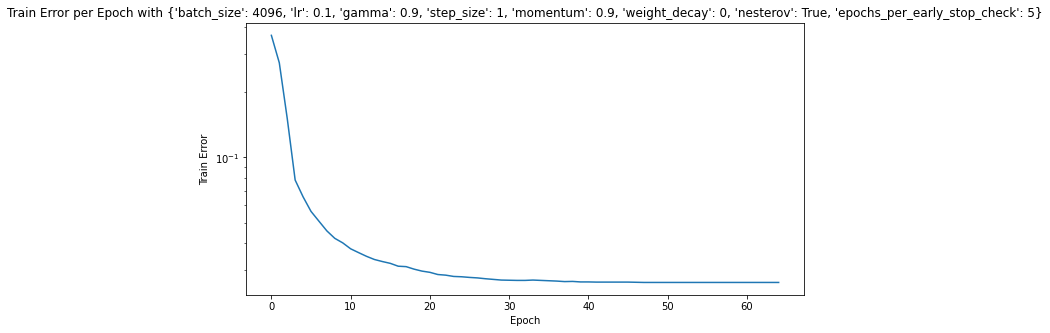

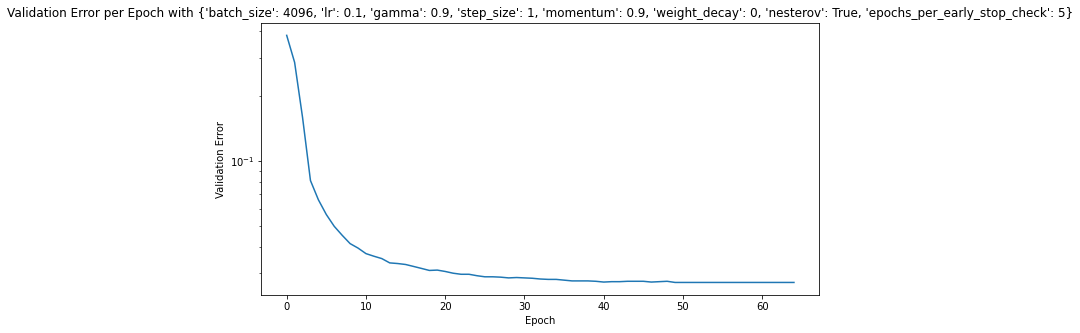

In [ ]:
train_net(net.to(device), parameters)

In [ ]:
PATH = "/content/state_dicts/" + str(parameters) + ".pt"

In [ ]:
torch.save(net.state_dict(), PATH)

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
parameters={"batch_size": 2**8, "lr": 0.2, "gamma":0.9, "step_size": 2, "momentum": 0.9, "weight_decay": 0, "nesterov": True}
net = Net()
net.load_state_dict(torch.load("/content/state_dicts/" + str(parameters) + ".pt"))
acc_train, loss_train, acc_val, loss_val = train_val_acc_eval_f(net.cuda().eval())
print(f"\tTrain err: {100-acc_train*100:.5f}%, train loss: {loss_train}")
print(f"\tValidation err: {100-acc_val*100:.5f}%, validation loss: {loss_val}\n")

	Train err: 0.00000%, train loss: 0.0001996844643708896
	Validation err: 0.97230%, validation loss: 0.042836139972783405



In [ ]:
train_test_acc_eval_f(net)

Train err: 0.00%, train loss: 0.00019968445818914577
TEST ERR: 1.33%, test loss: 0.05709494277987256


## Compression using the LC toolkit
### Step 1: L step
We will use same L step with same hyperparamters for all our compression examples

In [ ]:
# l_step_parameters: keep parameters 
#   learning rate: 0.7*(0.98**step), 
#   epochs per step: 7, 

# quantization parameters: codebook size (k) - powers of 2
# low rank parameters: alpha - higher alpha gives greater compression

In [ ]:
def my_l_step(model, lc_penalty, step):
    train_loader, val_loader, test_loader = data_loader()
    params = list(filter(lambda p: p.requires_grad, model.parameters()))
    # ------------------- Learning rate parameter
    lr = 0.7*(0.98**step)
    # -------------------------------------------
    optimizer = optim.SGD(params, lr=lr, momentum=0.9, nesterov=True)
    print(f'L-step #{step} with lr: {lr:.5f}')
    epochs_per_step_ = 7
    if step == 0:
        epochs_per_step_ = epochs_per_step_ * 2
    for epoch in range(epochs_per_step_):
        avg_loss = []
        for x, target in train_loader:
            optimizer.zero_grad()
            x = x.to(device)
            target = target.to(dtype=torch.long, device=device)
            out = model(x)
            loss = model.loss(out, target) + lc_penalty()
            avg_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        print(f"\tepoch #{epoch} is finished.")
        print(f"\t  avg. train loss: {np.mean(avg_loss):.6f}")

### Step 2: Schedule of mu values

In [ ]:
# mu schedule parameters: mu value should start very low and increase

mu_s = [9e-5 * (1.1 ** n) for n in range(20)] # 0 to infinity
# 20 L-C steps in total
# total training epochs is 7 x 20 = 140

### Compression time! Pruning
Let us prune all but 5% of the weights in the network (5% = 13310 weights)

In [ ]:
parameters={"batch_size": 2**8, "lr": 0.2, "gamma":0.9, "step_size": 2, "momentum": 0.9, "weight_decay": 0, "nesterov": True, "epochs_per_early_stop_check": 3}
net = Net().cuda()
net.load_state_dict(torch.load("/content/state_dicts/" + str(parameters) + ".pt"))

# pruning parameter: kappa - controls how many weights will be in the compressed model (excluding biases)
#   model starting size (with biases): 266105
#   Starting number of weights: 265700
#   30x compression: kappa = 6700
#   5x compression: kappa = 46250
layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]
compression_tasks = {
    Param(layers, device): (AsVector, ConstraintL0Pruning(
            kappa=46250
          ), 'pruning')
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()                              # entry point to the LC algorithm

from retrieve 276.9761156987101
L0 constrained pruning.
l0-cons pruning finished. #zeros: 82.59%
Direct compression has been performed.
Train err: 0.00%, train loss: 0.0021809499061038328
TEST ERR: 1.39%, test loss: 0.05007311457078637
9e-05
L-step #0 with lr: 0.70000
	epoch #0 is finished.
	  avg. train loss: 0.004144
	epoch #1 is finished.
	  avg. train loss: 0.004109
from retrieve 276.05937899055033
L-step #0 has finished.
L0 constrained pruning.
l0-cons pruning finished. #zeros: 82.59%
C-step #0 has finished.
Lagrange multipliers have been updated.
Train err: 0.00%, train loss: 0.0020892680660539935
TEST ERR: 1.39%, test loss: 0.05023994376932429


In [ ]:
lc_alg.count_params()

46250

In [ ]:
compressed_model_bits = lc_alg.count_param_bits() + (300+100+5)*32
uncompressed_model_bits = (784*300+300*100+100*5 + 300 + 100 + 5)*32
compression_ratio = uncompressed_model_bits/compressed_model_bits
print(compression_ratio)

5.003181571678783


Note that we were pruning 95% of the weights. Naively, you would assume 20x compression ratio (100%/5%), however, this is not the case. Firstly, there are some uncompressed parts (in this case biases), and, secondly, storing a compressed model requires additional metadata (in this case positions of non-zero elements). Therefore we get only 16x compression ratio (vs naively expected 20x). 

To prevent manual computation of compression ratio, let us create a function below. Note, this function is model specific.

In [ ]:
def compute_compression_ratio(lc_alg):
    compressed_model_bits = lc_alg.count_param_bits() + (300+100+10)*32
    uncompressed_model_bits = (784*300+300*100+100*10 + 300 + 100 + 10)*32
    compression_ratio = uncompressed_model_bits/compressed_model_bits
    return compression_ratio

### Quantization
Now let us quantize each layer with its own codebook

In [ ]:
parameters={"batch_size": 2**8, "lr": 0.2, "gamma":0.9, "step_size": 2, "momentum": 0.9, "weight_decay": 0, "nesterov": True, "epochs_per_early_stop_check": 3}
net = Net().cuda()
net.load_state_dict(torch.load("/content/state_dicts/" + str(parameters) + ".pt"))

layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]
# k = 2 for each layer gives 30x compression
# k = 4 for each layer gives 15x compression
# k = 8 for each layer gives 10x compression
# k = 16 for each layer gives about 8x compression
# k = 32 for each layer gives about 6.2x compression
# k = 64 for each layer gives about 5.28x compresssion
# k = 128 for each layer gives about 4.5x compression

compression_tasks = {
    Param(layers[0], device): (AsVector, AdaptiveQuantization(k=128), 'layer0_quant'),
    Param(layers[1], device): (AsVector, AdaptiveQuantization(k=128), 'layer1_quant'),
    Param(layers[2], device): (AsVector, AdaptiveQuantization(k=128), 'layer2_quant')
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()  
print('Compressed_params:', lc_alg.count_params())
print('Compression_ratio:', compute_compression_ratio(lc_alg))

from retrieve 174.84155325678307
from retrieve 69.29116793712554
from retrieve 32.8433945048008
None k-means++
K-Means converged in 300 iterations.
None k-means++
K-Means converged in 39 iterations.
None k-means++
K-Means converged in 4 iterations.
Direct compression has been performed.
Train err: 0.00%, train loss: 0.0002007996704738024
TEST ERR: 1.31%, test loss: 0.05693264790107867
9e-05
L-step #0 with lr: 0.70000
	epoch #0 is finished.
	  avg. train loss: 0.000197
	epoch #1 is finished.
	  avg. train loss: 0.000204
from retrieve 175.0665561670807
from retrieve 69.5178068935247
from retrieve 33.07397414575733
L-step #0 has finished.
{'cluster_centers': array([[ 0.08340073],
       [-0.00807121],
       [ 0.02971549],
       [-0.03673408],
       [ 0.01219443],
       [-0.08436   ],
       [-0.02212693],
       [ 0.05087376],
       [ 0.00262428],
       [-0.01590441],
       [-0.04851483],
       [ 0.019622  ],
       [-0.06808996],
       [ 0.0353951 ],
       [-0.02744987],
      

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Mixing pruning, low rank, and quantization

In [ ]:
net = load_reference_lenet300()
layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]

compression_tasks = {
    Param(layers[0], device): (AsVector, ConstraintL0Pruning(kappa=5000), 'pruning'),
    Param(layers[1], device): (AsIs, LowRank(target_rank=9, conv_scheme=None), 'low-rank'),
    Param(layers[2], device): (AsVector, AdaptiveQuantization(k=2), 'quant')
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()
print('Compressed_params:', lc_alg.count_params())
print('Compression_ratio:', compute_compression_ratio(lc_alg))

### Additive combination of Quantization and Pruning

In [ ]:
net = load_reference_lenet300()
layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]

compression_tasks = {
    Param(layers, device): [
        (AsVector, ConstraintL0Pruning(kappa=2662), 'pruning'),
        (AsVector, AdaptiveQuantization(k=2), 'quant')
    ]
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()
print('Compressed_params:', lc_alg.count_params())
print('Compression_ratio:', compute_compression_ratio(lc_alg))

### Low-rank compression with automatic rank selection

In [ ]:
parameters={"batch_size": 2**8, "lr": 0.2, "gamma":0.9, "step_size": 2, "momentum": 0.9, "weight_decay": 0, "nesterov": True, "epochs_per_early_stop_check": 3}
net = Net().cuda()
net.load_state_dict(torch.load("/content/state_dicts/" + str(parameters) + ".pt"))

layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]
# 
alpha=1e-9
compression_tasks = {
    Param(layers[0], device): (AsIs, RankSelection(conv_scheme='scheme_1', alpha=alpha, criterion='storage', module=layers[0], normalize=True), "layer1_lr"),
    Param(layers[1], device): (AsIs, RankSelection(conv_scheme='scheme_1', alpha=alpha, criterion='storage', module=layers[1], normalize=True), "layer2_lr"),
    Param(layers[2], device): (AsIs, RankSelection(conv_scheme='scheme_1', alpha=alpha, criterion='storage', module=layers[2], normalize=True), "layer3_lr")
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()
print('Compressed_params:', lc_alg.count_params())
print('Compression_ratio:', compute_compression_ratio(lc_alg))

from retrieve 174.84155325678307
from retrieve 69.29116793712554
from retrieve 32.8433945048008
for this layer, selected rank is 0, normalized ‖w‖²=1.000, true ‖w‖²=174.842, ‖Δ(Θ)‖²=0.000, ‖w-Δ(Θ)‖²=1.000e+00, μ should be at least 3.56e-05
for this layer, selected rank is 0, normalized ‖w‖²=1.000, true ‖w‖²=69.291, ‖Δ(Θ)‖²=0.000, ‖w-Δ(Θ)‖²=1.000e+00, μ should be at least 5.33e-06
for this layer, selected rank is 0, normalized ‖w‖²=1.000, true ‖w‖²=32.843, ‖Δ(Θ)‖²=0.000, ‖w-Δ(Θ)‖²=1.000e+00, μ should be at least 6.86e-07
Direct compression has been performed.
Train err: 81.84%, train loss: 1.6619303559148035
TEST ERR: 81.76%, test loss: 1.662122472322304
9e-05
L-step #0 with lr: 0.70000
	epoch #0 is finished.
	  avg. train loss: 0.012653
	epoch #1 is finished.
	  avg. train loss: 0.012555
from retrieve 171.86938748091544
from retrieve 68.25885266920355
from retrieve 32.485757136050466
L-step #0 has finished.
for this layer, selected rank is 6, normalized ‖w‖²=1.000, true ‖w‖²=171.869, ‖

### ScaledBinaryQuantization

In [ ]:
from lc.compression_types import ScaledBinaryQuantization
net = load_reference_lenet300()
layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]

compression_tasks = {
    Param(layers[0], device): (AsVector, ScaledBinaryQuantization(), 'layer0_quant'),
    Param(layers[1], device): (AsVector, ScaledBinaryQuantization(), 'layer1_quant'),
    Param(layers[2], device): (AsVector, ScaledBinaryQuantization(), 'layer2_quant')
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run()
print('Compressed_params:', lc_alg.count_params())
print('Compression_ratio:', compute_compression_ratio(lc_alg))

### ScaledTernaryQuantization

In [ ]:
from lc.compression_types import ScaledTernaryQuantization
net = load_reference_lenet300()
layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]

compression_tasks = {
    Param(layers[0], device): (AsVector, ScaledTernaryQuantization(), 'layer0_quant'),
    Param(layers[1], device): (AsVector, ScaledTernaryQuantization(), 'layer1_quant'),
    Param(layers[2], device): (AsVector, ScaledTernaryQuantization(), 'layer2_quant')
}

lc_alg = lc.Algorithm(
    model=net,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run() 
print('Compressed_params:', lc_alg.count_params())
print('Compression_ratio:', compute_compression_ratio(lc_alg))